## Monte Carlo Simulation

The COVID scare was a wake-up call, highlighting the vulnerability of our hyper-connected modern world to the threat of pandemics. Now that the COVID urgency has passed, governments across the globe are rushing to update their emergency action plans and disaster scripts.

As part of this effort, you’ve been hired by a medical team that has been tasked with developing fast procedures to detect a blood-borne virus. 

Since these tests need to be administered to large groups in the population, and testing resources are limited, the medics have come up with the following procedure: 

1. They started from the assumption that they need to test $N$ blood samples (of as many different individuals) and that $N$ is large (e.g., $N = 10^6$). 
2. Furthermore, the probability that an individual is infected is $p$, where $p$ is relatively small, e.g., $p < 0.1$.

Based on these assumptions they propose the following procedure to minimise the number of tests they have to run: Rather than testing each sample individually, take a batch of $k$ samples and mix them. Then this mixed sample is tested for the presence of the viral antigen:

- If the mixed sample tests **negative** (i.e., no viral antigen is detected), then all the individual samples were clear, and you therefore have the result for all $k$ individual samples that went into the batch.
- If the mixed sample tests **positive** (i.e., the viral antigen is present indicating infection), one needs to retest all individual samples that went into the batch, in order to find out which individual(s) are actually infected.

**Questions**
1. Use Monte Carlo simulation to estimate the optimal batch size $k$ (i.e., the one that minimises the expected number of tests) for a given value of $p$ where $p$ can take values between $10^{-1}$ and $10^{-4}$.
2. In order to convince your superiors that this a good investment, quantify the **expected reduction in workload** (compared to testing all samples individually).

### Class and Functions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
class Monte_Carlo:
    def __init__(self, 
                 probability, 
                 batch_size, 
                 sample_size = 1000000):
        self.p = probability
        self.k = batch_size
        self.N = sample_size
    
    # Calculate X
    def generate_sample(self):
        # Generate and return a random sample
        return np.random.choice(
            a=[1, 0], # positive / negative
            size=self.N, 
            p=[self.p, 1-self.p])
    
    # Calculate Expected Number of Tests
    def calculate_n_tests(self):
        # Getting the random sample
        X = self.generate_sample()

        # Counter for Number of Tests
        n_tests = 0

        # Splitting the sample into batches and counting tests
        for i in range(0, len(X), self.k):
            batch = X[i:i + self.k]
            # Testing the batch
            n_tests += 1
            # If any positive, test everyone individually
            if any(individual == 1 for individual in batch):  # If any positive, test each individually
                n_tests += len(batch)
    
        return n_tests
    
    # Calculating the Expected Probability and SD of Finding a Positive in a Given Batch
    def probability_positive_in_batch(self):
        # Getting the random sample
        X = self.generate_sample()
        
        # List for Storing the Results
        all_results = []

        # Dividing the samples
        samples = [X[i:i + self.k] for i in range(0, len(X), self.k)]

        # Testing all Samples
        all_results = [any(individual == 1 for individual in batch) for batch in samples]

        # Getting the Expected Probability and SD
        MC_mean = np.mean(all_results)
        MC_mean_sd = np.std(all_results) / np.sqrt(self.N)

        return {"e_mean": MC_mean, "e_mean_sd": MC_mean_sd}


In [4]:
def simulate_monte_carlo(probabilities, k_values, sample_size=100000):
    # Initialize an empty DataFrame
    results_df = pd.DataFrame(index=k_values, columns=probabilities)

    # Iterating over the different Batch Sizes
    for k in k_values:
        # Iterating over the different Probabilities
        for p in probabilities:
            monte_carlo = Monte_Carlo(probability=p, batch_size=k, sample_size=sample_size)
            n_tests = monte_carlo.calculate_n_tests()
            results_df.loc[k, p] = n_tests

    return results_df

In [6]:
def find_optimal_batch_size(df):
    optimal_batches = {}

    for p in df.columns:
        optimal_k = df[p].idxmin()
        optimal_batches[p] = optimal_k

    return optimal_batches

In [9]:
def plot_MC_sim(df):
    # Define color mapping
    distinct_colors = plt.cm.tab20(np.linspace(0, 1, 20))  # 20 distinct colors
    # More gradual colors for k > 20
    gradual_colors = plt.cm.viridis(np.linspace(0, 1, len(df.index) - 20))
    
    # Combine color lists
    colors = np.vstack((distinct_colors, gradual_colors))

    plt.figure(figsize=(14, 8))
    
    # Plot each batch size with its color
    for i, k in enumerate(df.index):
        if k <= 20 or k % 10 == 0:
            label = f'Batch Size: {k}'
        else:
            label = None  # Only label specific lines
        plt.plot(df.columns, df.loc[k], color=colors[i], label=label)

    # Add a dashed horizontal line at y = 1000000
    plt.axhline(y=1000000, color='red', linestyle='--', linewidth=2)

    # Add labels and title
    plt.xlabel('Probability')
    plt.ylabel('Number of Tests')
    plt.title('Number of Tests by Batch Size and Probability')
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.show()


In [45]:
import plotly.graph_objs as go
import numpy as np
import matplotlib.pyplot as plt

def plot_interactive_monte_carlo(results_df, title='Number of Tests by Batch Size and Probability', horizontal_line_y=1000000):
    # Assuming you are working in a Jupyter notebook environment
    init_notebook_mode(connected=True)  # Uncomment this if in Jupyter

    # Create an empty list to hold all the plot traces
    traces = []

    # Define color mapping
    distinct_colors = plt.cm.tab20(np.linspace(0, 1, 15))  # 20 distinct colors
    gradual_colors = plt.cm.viridis(np.linspace(0, 1, len(results_df.index) - 15))
    colors = np.vstack((distinct_colors, gradual_colors))

    # Convert the colors to hex format for Plotly
    colors_hex = ['rgb({}, {}, {})'.format(int(c[0]*255), int(c[1]*255), int(c[2]*255)) for c in colors]

    # Add a trace for each batch size
    for i, k in enumerate(results_df.index):
        traces.append(go.Scatter(
            x=results_df.columns,
            y=results_df.loc[k],
            mode='lines',
            name=f'Batch Size: {k}',
            line=dict(color=colors_hex[i])
        ))

    # Define the layout of the plot
    layout = go.Layout(
        title=title,
        xaxis=dict(title='Probability'),
        yaxis=dict(title='Number of Tests', range=[0, results_df.values.max() + results_df.values.max() * 0.1]),
        hovermode='closest'
    )

    # Define the figure
    fig = go.Figure(data=traces, layout=layout)

    # Add a horizontal line at y = horizontal_line_y
    fig.add_shape(
        type='line',
        x0=results_df.columns.min(),
        y0=horizontal_line_y,
        x1=results_df.columns.max(),
        y1=horizontal_line_y,
        line=dict(dash='dash', color='grey', width=1)
    )

    # Show the figure
    # fig.show()  # Use iplot(fig) if within Jupyter Notebook, fig.show() if not
    return(fig)

### Sim 1: P: 0.0001 - 0.1000 (0.005), k: 2 - 100

In [7]:
# Blood Samples
N = 1000000

# Probabilities: from 0.1 to 0.0001
start = 0.0001
end =   0.1000
step =  0.0050
probabilities = np.arange(start, end + step, step)

# Probabilities: from 0.1 to 0.0001
batch_sizes = range(2,100)

# Simulation
sim_1 = simulate_monte_carlo(probabilities, batch_sizes, sample_size=N)

In [42]:
# Saving the dataframe
sim_1.to_csv('../MAS - Individual Assignment/sim_1.csv', index=True)

In [15]:
# Optimal Batch Size
sim_1_optimals = find_optimal_batch_size(sim_1)
print(sim_1_optimals)

{0.0001: 76, 0.0051: 15, 0.0101: 10, 0.015099999999999999: 8, 0.0201: 8, 0.0251: 7, 0.0301: 6, 0.035100000000000006: 6, 0.040100000000000004: 6, 0.0451: 5, 0.050100000000000006: 5, 0.0551: 5, 0.0601: 5, 0.0651: 4, 0.07010000000000001: 4, 0.0751: 4, 0.0801: 4, 0.08510000000000001: 4, 0.0901: 4, 0.0951: 4, 0.10010000000000001: 4}


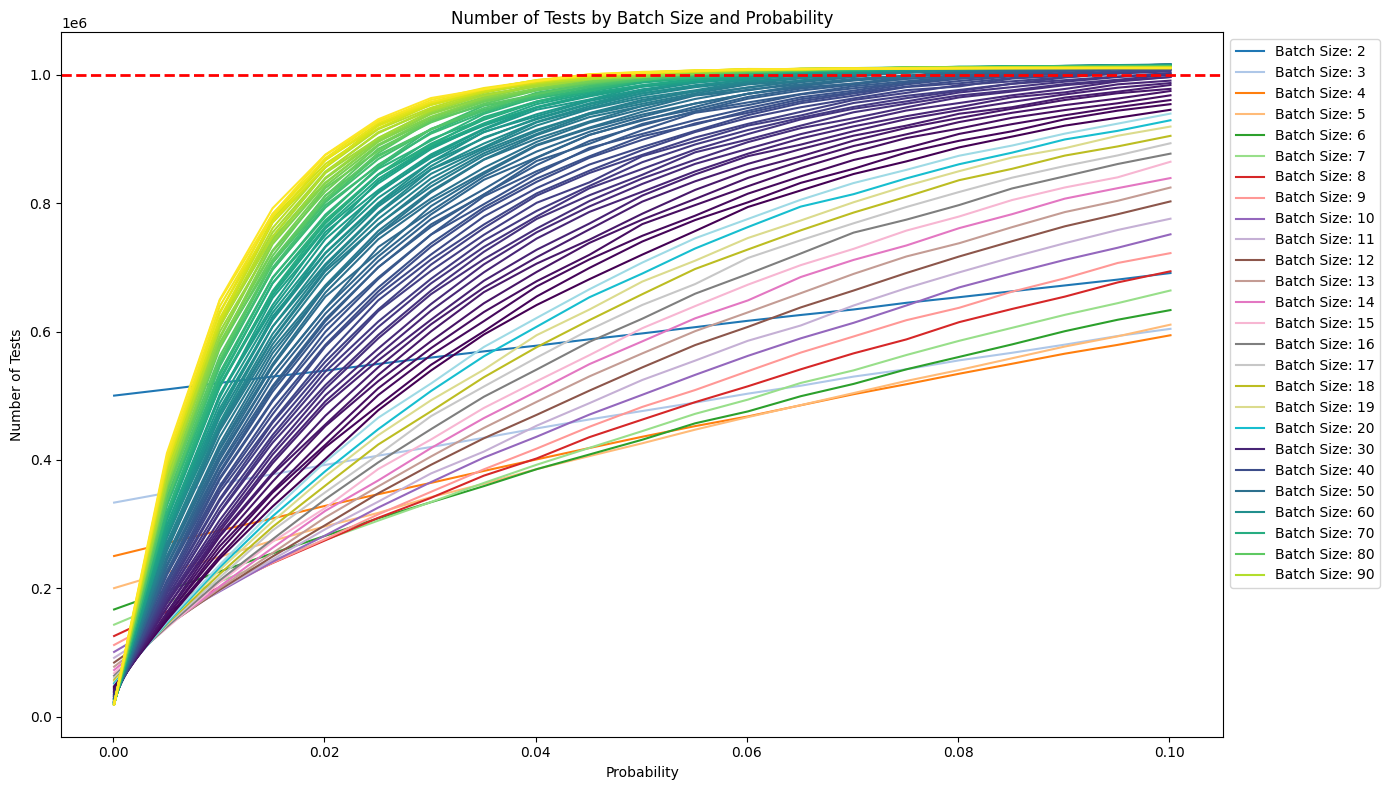

In [10]:
# Plotting
plot_MC_sim(sim_1)

In [32]:
sim_1_plotly = plot_interactive_monte_carlo(sim_1)
iplot(sim_1_plotly)

In [51]:
from plotly.offline import plot
plot(sim_1_plotly, filename='sim_1_plot.html')

'sim_1_plot.html'

### Sim 2: P: 0.0001 - 0.0050 (0.0001), k: 15 - 100

In [16]:
# Blood Samples
N = 1000000

# Probabilities: from 0.1 to 0.0001
start = 0.0001
end =   0.0050
step =  0.0001
probabilities = np.arange(start, end + step, step)

# Probabilities: from 0.1 to 0.0001
batch_sizes = range(15,100)

# Simulation
sim_2 = simulate_monte_carlo(probabilities, batch_sizes, sample_size=N)

In [43]:
# Saving the dataframe
sim_2.to_csv('../MAS - Individual Assignment/sim_2.csv', index=True)

In [17]:
# Optimal Batch Size
sim_2_optimals = find_optimal_batch_size(sim_2)
print(sim_2_optimals)

{0.0001: 94, 0.0002: 87, 0.00030000000000000003: 75, 0.0004: 51, 0.0005: 43, 0.0006000000000000001: 47, 0.0007000000000000001: 41, 0.0008: 42, 0.0009000000000000001: 38, 0.001: 39, 0.0011: 40, 0.0012000000000000001: 33, 0.0013000000000000002: 31, 0.0014000000000000002: 27, 0.0015: 27, 0.0016: 23, 0.0017000000000000001: 22, 0.0018000000000000002: 24, 0.0019000000000000002: 25, 0.002: 24, 0.0021: 20, 0.0022: 21, 0.0023: 23, 0.0024: 21, 0.0025: 22, 0.0026: 23, 0.0027: 17, 0.0028: 18, 0.0029: 20, 0.003: 21, 0.0031: 18, 0.0032: 19, 0.0033: 18, 0.0034: 18, 0.0035: 17, 0.0036: 16, 0.0037: 17, 0.0038: 15, 0.0039: 15, 0.004: 16, 0.0041: 17, 0.004200000000000001: 15, 0.004300000000000001: 15, 0.0044: 15, 0.0045000000000000005: 15, 0.004600000000000001: 15, 0.0047: 17, 0.0048000000000000004: 15, 0.004900000000000001: 15, 0.005: 16}


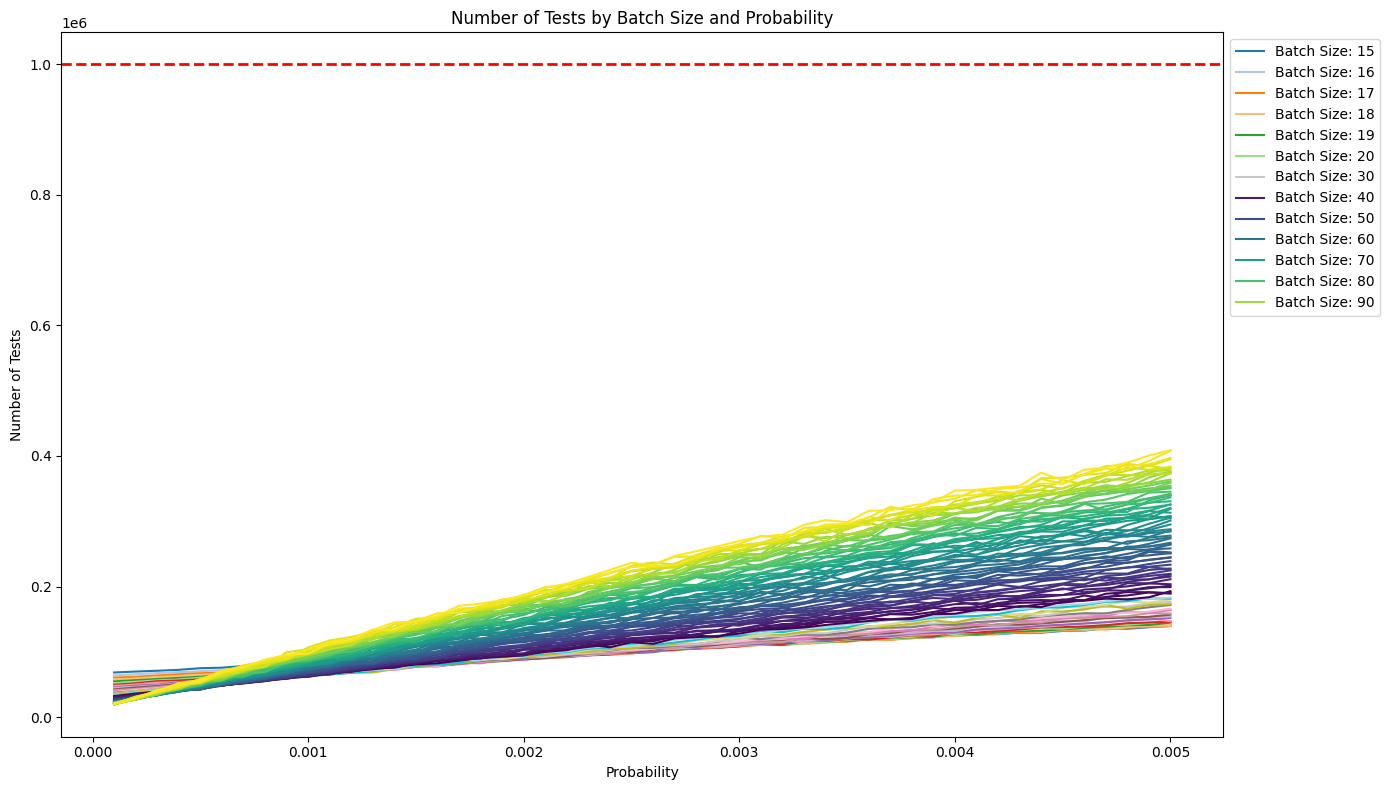

In [19]:
# Plotting
plot_MC_sim(sim_2)

In [34]:
sim_2_plotly = plot_interactive_monte_carlo(sim_2)
iplot(sim_2_plotly)

In [50]:
from plotly.offline import plot
plot(sim_2_plotly, filename='sim_2_plot.html')

'sim_2_plot.html'

### Sim 3: P: 0.005 - 0.10 (0.0001), k: 2 - 20

In [35]:
# Blood Samples
N = 1000000

# Probabilities: from 0.1 to 0.0001
start = 0.0100
end =   0.1000
step =  0.0001
probabilities = np.arange(start, end + step, step)

# Probabilities: from 0.1 to 0.0001
batch_sizes = range(2,20)

# Simulation
sim_3 = simulate_monte_carlo(probabilities, batch_sizes, sample_size=N)

In [41]:
# Saving the dataframe
sim_3.to_csv('../MAS - Individual Assignment/sim_3.csv', index=True)

In [39]:
# Optimal Batch Size
sim_3_optimals = find_optimal_batch_size(sim_3)
print(sim_3_optimals)

{0.01: 10, 0.0101: 10, 0.010199999999999999: 11, 0.010299999999999998: 10, 0.010399999999999998: 11, 0.010499999999999997: 11, 0.010599999999999997: 10, 0.010699999999999996: 10, 0.010799999999999995: 11, 0.010899999999999995: 11, 0.010999999999999994: 10, 0.011099999999999994: 10, 0.011199999999999993: 11, 0.011299999999999992: 10, 0.011399999999999992: 10, 0.011499999999999991: 10, 0.01159999999999999: 10, 0.01169999999999999: 9, 0.01179999999999999: 10, 0.011899999999999989: 11, 0.011999999999999988: 9, 0.012099999999999988: 10, 0.012199999999999987: 9, 0.012299999999999986: 9, 0.012399999999999986: 9, 0.012499999999999985: 9, 0.012599999999999984: 9, 0.012699999999999984: 9, 0.012799999999999983: 9, 0.012899999999999983: 9, 0.012999999999999982: 10, 0.013099999999999981: 9, 0.01319999999999998: 10, 0.01329999999999998: 10, 0.01339999999999998: 10, 0.013499999999999979: 10, 0.013599999999999978: 9, 0.013699999999999978: 9, 0.013799999999999977: 9, 0.013899999999999977: 9, 0.01399999

In [46]:
sim_3_plotly = plot_interactive_monte_carlo(sim_3)
iplot(sim_3_plotly)

In [48]:
from plotly.offline import plot
plot(sim_3_plotly, filename='sim_3_plot.html')

'sim_3_plot.html'

In [49]:
sim_3.mean(axis=1)

2     606383.611973
3     487609.702882
4     449052.208426
5     440860.443459
6     446584.226164
7     459380.227273
8     475757.232816
9      493896.22949
10    512872.128603
11    531922.021064
12    550749.237251
13    569237.829268
14    587031.141907
15    604308.513304
16    620793.002217
17    636586.342572
18    651685.789357
19    665981.174058
dtype: object

### Sim 4

In [ ]:
# Blood Samples
N = 1000000

# Probabilities: from 0.1 to 0.0001
start = 0.0001
end =   0.1000
step =  0.0001
probabilities = np.arange(start, end + step, step)

# Probabilities: from 0.1 to 0.0001
batch_sizes = range(2,8)

# Simulation
sim_3 = simulate_monte_carlo(probabilities, batch_sizes, sample_size=N)

In [16]:
# Assuming simulation_results_df is already obtained from your simulations
optimal_batch_sizes = estimate_optimal_batch_size(simulation_results_df)
print(optimal_batch_sizes)

{0.0001: 92, 0.0101: 11, 0.0201: 7, 0.0301: 7, 0.040100000000000004: 5, 0.050100000000000006: 5, 0.0601: 5, 0.07010000000000001: 4, 0.0801: 4, 0.0901: 4, 0.10010000000000001: 4}


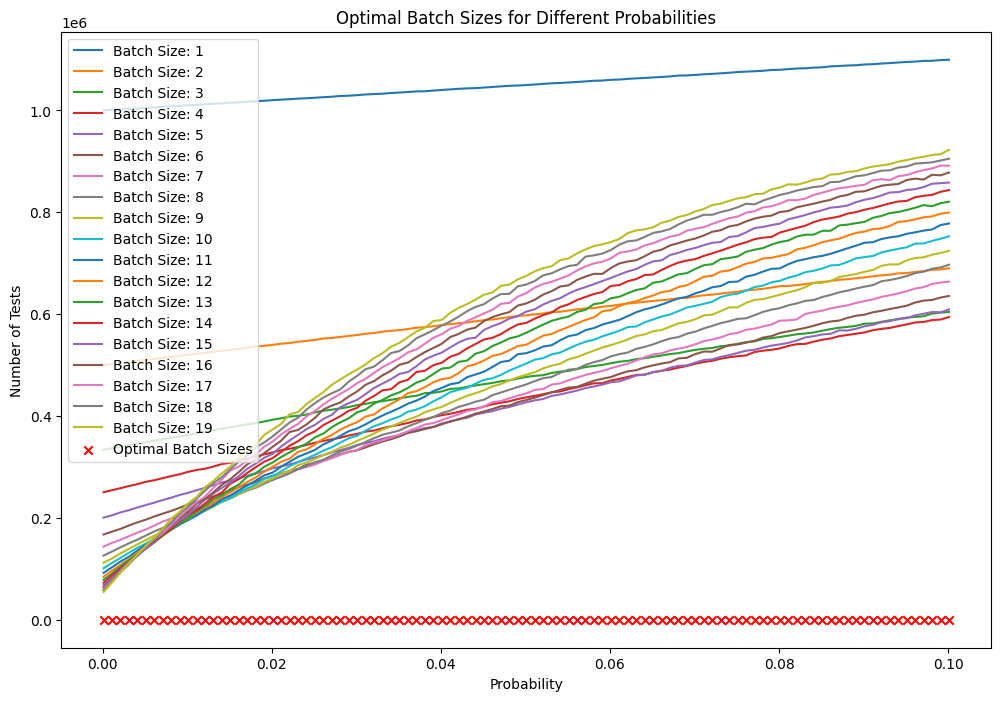

In [14]:
def plot_with_optimal_batches(results_df, optimal_batch_sizes):
    plt.figure(figsize=(12, 8))

    # Plot the simulation results
    for k in results_df.index:
        plt.plot(results_df.columns, results_df.loc[k], label=f'Batch Size: {k}')

    # Overlay the optimal batch sizes
    optimal_probabilities = list(optimal_batch_sizes.keys())
    optimal_k_values = [optimal_batch_sizes[p] for p in optimal_probabilities]
    plt.scatter(optimal_probabilities, optimal_k_values, color='red', marker='x', label='Optimal Batch Sizes')

    plt.xlabel('Probability')
    plt.ylabel('Number of Tests')
    plt.title('Optimal Batch Sizes for Different Probabilities')
    plt.legend()
    plt.show()

# Call the function to plot
plot_with_optimal_batches(simulation_results_df, optimal_batch_sizes)


In [ ]:
def simulate_monte_carlo(probabilities, k_values, sample_size=1000000):
    # Dictionary to save results
    results = {}

    # Iterating over the different Batch Sizes
    for k in k_values:
        # List to save different Probabilities for a given Batch Size
        tests_per_k = []

        # Iterating over the different Probabilities
        for p in probabilities:
            monte_carlo = Monte_Carlo(probability=p, batch_size=k, sample_size=sample_size)
            n_tests = monte_carlo.calculate_n_tests()
            tests_per_k.append(n_tests)
        results[k] = tests_per_k

    return results

In [ ]:
def plot_simulation_results(results, probabilities):
    plt.figure(figsize=(12, 6))
    
    for k, test_counts in results.items():
        plt.plot(probabilities, test_counts, label=f'Batch Size: {k}')
    
    plt.xlabel('Probability')
    plt.ylabel('Number of Tests')
    plt.title('Number of Tests by Batch Size and Probability')
    plt.legend()
    plt.show()


### Plotly

In [12]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# Assuming you are working in a Jupyter notebook environment
# init_notebook_mode(connected=True)  # Use in a Jupyter notebook to display the plot within the notebook

# Create an empty list to hold all the plot traces
traces = []

# Define color mapping
distinct_colors = plt.cm.tab20(np.linspace(0, 1, 20))  # 20 distinct colors
gradual_colors = plt.cm.viridis(np.linspace(0, 1, len(sim_1.index) - 20))
colors = np.vstack((distinct_colors, gradual_colors))

# Convert the colors to hex format for Plotly
colors_hex = ['rgb({}, {}, {})'.format(int(c[0]*255), int(c[1]*255), int(c[2]*255)) for c in colors]

# Add a trace for each batch size
for i, k in enumerate(sim_1.index):
    traces.append(go.Scatter(
        x=sim_1.columns,
        y=sim_1.loc[k],
        mode='lines',
        name=f'Batch Size: {k}',
        line=dict(color=colors_hex[i])
    ))

# Define the layout of the plot
layout = go.Layout(
    title='Number of Tests by Batch Size and Probability',
    xaxis=dict(title='Probability'),
    yaxis=dict(title='Number of Tests', range=[0, sim_1.values.max() + sim_1.values.max() * 0.1]),
    hovermode='closest'
)

# Define the figure
fig = go.Figure(data=traces, layout=layout)

# Add a horizontal line at y = 1000000
fig.add_shape(
    type='line',
    x0=sim_1.columns.min(),
    y0=1000000,
    x1=sim_1.columns.max(),
    y1=1000000,
    line=dict(dash='dash', color='grey', width=1)
)

# Show the figure
iplot(fig)


In [14]:
from plotly.offline import plot
plot(fig, filename='interactive_plot.html')

'interactive_plot.html'

In [ ]:
# Function to plot number of tests performed against probability for different batch sizes
def plot_number_of_tests(probabilities, k_values, sample_size=100000):
    results = {}

    # Iterate over probabilities and k_values
    for k in k_values:
        test_counts = []
        for p in probabilities:
            _, _, n_test = monte_carlo_sampling(p, k, sample_size)
            test_counts.append(n_test)
        results[k] = test_counts
    
    # Plotting the results
    plt.figure(figsize=(12, 6))
    for k, test_counts in results.items():
        plt.plot(probabilities, test_counts, label=f'Batch Size: {k}')

    plt.xlabel('Probability')
    plt.ylabel('Number of Tests')
    plt.title('Number of Tests by Batch Size and Probability')
    plt.legend()
    # plt.ylim(0, 30000)  # Setting the y-axis limit
    plt.show()

# Define probabilities and k values
probabilities = np.linspace(0.0001, 0.1000, 100)  # Using linspace for evenly spaced probabilities
k_values = range(1000, 1001)

# Call the function to plot
plot_number_of_tests(probabilities, k_values)

In [96]:
X = np.random.choice(
        a=[1, 0], # positive / negative
        size=100000, 
        p=[0.1, 0.9])
a, n_te = MC_F(X, 20)
np.mean(a)
n_te

overall_results = []
        overall_results.append(result)
return overall_results

88201

In [93]:
def MC_F(X, k):
    samples = [X[i:i + k] for i in range(0, len(X), k)]

    # Counter for Number of Tests
    n_test = 0

    for sample in samples:
        # testing the batch
        n_test += 1
        # Getting the result for the batch
        result = all(individual == 0 for individual in sample)
        # If not, we need to test everyone again
        if result == False:
            n_test += k

    return n_test

In [67]:
def monte_carlo_sampling(probability, batch_size, sample_size = 100000):
    X = np.random.choice(
        a=[1, 0], # positive / negative
        size=sample_size, 
        p=[probability, 1-probability])
    
    k = batch_size
    F, n_test = MC_F(X, k)
    
    # Compute the Monte Carlo estimate by computing the sample average:
    # Sample Average:
    m_mc = np.mean(F)
    
    # Compute the standard deviation for the sample mean
    m_mc_std = np.std(F) / np.sqrt(sample_size)
    return (m_mc, m_mc_std, n_test)

In [58]:
probabilities = np.random.uniform(
    low=0.0001, 
    high=0.1, 
    size=100000)

k_values = range(1,11)

In [12]:
x.stdev

F = np.random.choice(
    X, 
    size=k, 
    replace=False)




random_samples = [np.random.choice(data, size=size, replace=False) for size in sample_sizes]

5

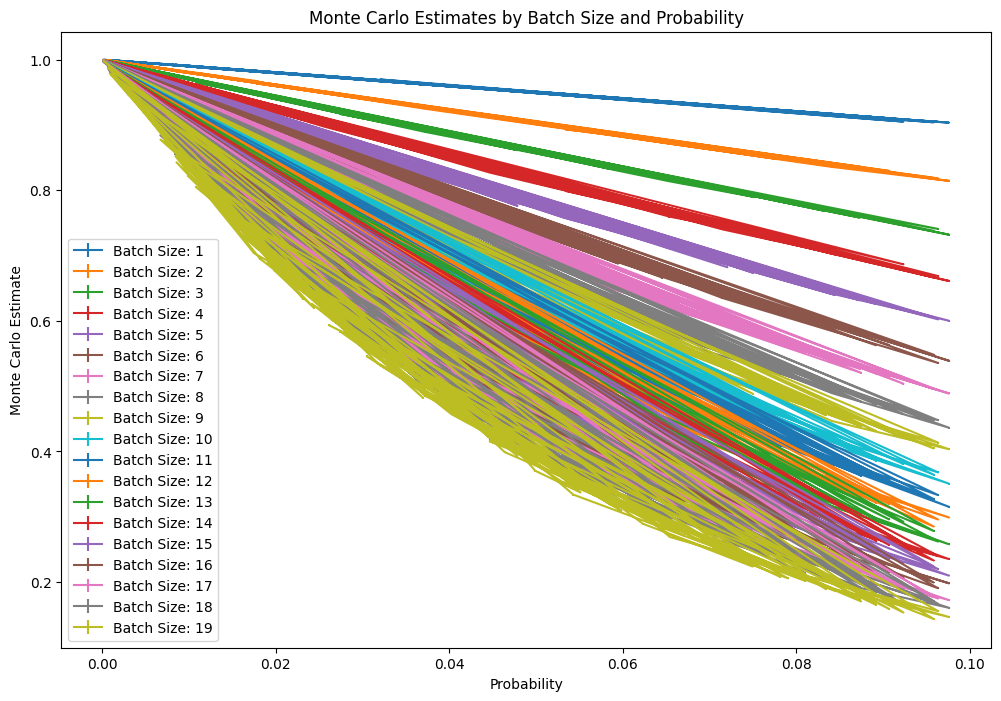

In [60]:
# Wrapper function to iterate over different k values and probabilities
def simulate_and_plot(probabilities, k_values, sample_size=100000):
    results = {}

    # Iterate over probabilities and k_values
    for k in k_values:
        for p in probabilities:
            m_mc, m_mc_std = monte_carlo_sampling(p, k, sample_size)
            results[(k, p)] = (m_mc, m_mc_std)
    
    # Plot the results
    plt.figure(figsize=(12, 8))
    for k in k_values:
        x = []  # probabilities
        y = []  # Monte Carlo estimates
        yerr = []  # Standard deviations
        for p in probabilities:
            x.append(p)
            y.append(results[(k, p)][0])
            yerr.append(results[(k, p)][1])
        plt.errorbar(x, y, yerr=yerr, label=f'Batch Size: {k}')

    plt.xlabel('Probability')
    plt.ylabel('Monte Carlo Estimate')
    plt.title('Monte Carlo Estimates by Batch Size and Probability')
    plt.legend()
    plt.show()

# Define probabilities and k values
probabilities = np.random.uniform(low=0.0001, high=0.1000, size=100)
k_values = range(1, 20)

# Call the function to simulate and plot
simulate_and_plot(probabilities, k_values)


In [64]:
# Updated function to simulate and plot
def simulate_and_plot(probabilities, k_values, sample_size=100000):
    results = {}

    # Iterate over probabilities and k_values
    for k in k_values:
        for p in probabilities:
            m_mc, m_mc_std, n_test = monte_carlo_sampling(p, k, sample_size)
            results[(k, p)] = (m_mc, m_mc_std, n_test)
    
    # Plot the results
    plt.figure(figsize=(12, 8))

    # Plot for Monte Carlo estimates
    plt.subplot(1, 2, 1)
    for k in k_values:
        x = []  # probabilities
        y = []  # Monte Carlo estimates
        yerr = []  # Standard deviations
        for p in probabilities:
            x.append(p)
            y.append(results[(k, p)][0])
            yerr.append(results[(k, p)][1])
        plt.errorbar(x, y, yerr=yerr, label=f'Batch Size: {k}')

    plt.xlabel('Probability')
    plt.ylabel('Monte Carlo Estimate')
    plt.title('Monte Carlo Estimates by Batch Size and Probability')
    plt.legend()

    # Plot for number of tests
    plt.subplot(1, 2, 2)
    for k in k_values:
        x = []  # probabilities
        y = []  # Number of tests
        for p in probabilities:
            x.append(p)
            y.append(results[(k, p)][2])
        plt.plot(x, y, label=f'Batch Size: {k}')

    plt.xlabel('Probability')
    plt.ylabel('Number of Tests')
    plt.title('Number of Tests by Batch Size and Probability')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Define probabilities and k values
probabilities = np.random.uniform(low=0.0001, high=0.1000, size=100)
k_values = range(1, 11)

# Call the function to simulate and plot
simulate_and_plot(probabilities, k_values)


ValueError: not enough values to unpack (expected 3, got 2)

In [1]:
# Function to plot number of tests performed against probability for different batch sizes
def plot_number_of_tests(probabilities, k_values, sample_size=100000):
    results = {}

    # Iterate over probabilities and k_values
    for k in k_values:
        test_counts = []
        for p in probabilities:
            _, _, n_test = monte_carlo_sampling(p, k, sample_size)
            test_counts.append(n_test)
        results[k] = test_counts
    
    # Plotting the results
    plt.figure(figsize=(12, 6))
    for k, test_counts in results.items():
        plt.plot(probabilities, test_counts, label=f'Batch Size: {k}')

    plt.xlabel('Probability')
    plt.ylabel('Number of Tests')
    plt.title('Number of Tests by Batch Size and Probability')
    plt.legend()
    # plt.ylim(0, 30000)  # Setting the y-axis limit
    plt.show()

# Define probabilities and k values
probabilities = np.linspace(0.0001, 0.1000, 100)  # Using linspace for evenly spaced probabilities
k_values = range(1000, 1001)

# Call the function to plot
plot_number_of_tests(probabilities, k_values)

NameError: name 'np' is not defined

In [ ]:
simulate_and_plot

In [54]:
p = 0.0005
k = 1000
x = monte_carlo_sampling(p, k)
x

(0.55, 0.0015732132722552274)

In [7]:
sample = np.random.choice(
    a=[1, 0], # positive / negative
    size=4, 
    p=[0.1, 0.9])
sample

ValueError: probabilities do not sum to 1

In [ ]:

probabilities = np.random.uniform(
    low=0.0001, 
    high=0.1000, 
    size=100000)


# For different probability
probabilities = np.random.uniform(
    low=0.0001, 
    high=0.1000, 
    size=100000)

for p in probabilities:
    # ???


sample = np.random.choice(
    a=[1, 0], # positive / negative
    size=10^6, 
    p=[p, 1-p])


## Thompson Sampling for Multi-Armed Bandits